## Quantifying predictive accuracy: Trickier than it seems

### Russell A. Poldrack[1], Grace Huckins[1], and Gael Varoquaux[2]

[1] Department of Psychology and Interdepartmental Neurosciences Program, Stanford University

[2] INRIA

## Abstract

There is great interest in developing tools that can predict clinically or scientifically important outcomes from high-dimensional data such as neuroimaging or genomics data.  Our goal in this paper is to highlight several potential pitfalls in predictive modeling. First, we review current usage of the term "prediction" (specifically within the neuroimaging literature) and demonstrate that many published papers do not properly demonstrate prediction via testing on data separate from those used to fit the predictive model.  Second, we discuss the use of different possible measures of predictive performance, highlighting the limitations of some commonly used measures and the need for assessment using multiple measures of performance.  Third, we highlight a particular challenge in the application of cross-validation to continuously distributed outcome variables, demonstrating that the naive application of standard cross-validation techniques can result in badly biased results.  We end by proposing a set of best practices for predictive modeling.



In [1]:
import numpy,pandas
import seaborn
from sklearn.linear_model import LinearRegression,LogisticRegression,LogisticRegressionCV
from sklearn import model_selection,metrics
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import LeaveOneOut
import numpy as np
import csv
from matplotlib import pyplot as plt
from collections import Counter

import matplotlib.pyplot as plt


# this imports a function to do balanced cross validation
from get_balanced_folds import BalancedKFold

%matplotlib inline
# %load_ext rpy2.ipython

data = pandas.read_csv('litreviewdata.csv')   
# NOTE: using this strategy for references: 
# https://stackoverflow.com/questions/30061902/how-to-handle-citations-in-ipython-notebook


## Introduction

There is currently great interest in the development of "biomarkers" for disease, to serve as diagnostic markers or surrogate endpoints for clinical research. This interest is particular great for neuropsychiatric disorders, given the lack of biological tests for these diseases and their substantial economic and social impact [@woo:chan:lind:2017].  The development of such biomarkers generally proceeds through the establishment of a predictive relationship between the measure of interest and the outcome of interest.  However, a broad set of methods is used to establish such putative relationships.

In this tutorial paper we will review a number of challenges that arise in predictive modeling.  Most of these challenges are well known within the machine learning and statistics communities, though even in those literatures some of these points have not been sufficiently emphasized. We begin by outlining the meaning of the concept of "prediction" from the standpoint of machine learning, a field focused heavily on the development of methods for generalizable predictive models.  We highlight the fact that predictive accuracy cannot be established using the same data to both fit and test the model, which is a common error in published claims of "prediction."   We then turn to the question of how accuracy should be quantified, focusing heavily on the case of continuous outcome measures. We outline the ways in which naive use of particular predictive accuracy measures and crossvalidation methods can lead to strongly biased estimates of predictive accuracy.  We conclude by outlining a set of best practices to establish effective claims of predictive accuracy.


## What does "prediction" mean? A review of the neuroimaging literature

Let's say that an investigator publishes a report in which they claim to be able to predict a diagnosis of schizophrenia from brain imaging data with 90% accuracy.  Most readers would fairly assume that this implies that the method could be applied in a new sample of individuals with similar accuracy, as this is the common interpretation of the term "prediction".  However, the term "predict" is often used in context of analyses that would not actually support the kind of generalizable predictive accuracy that most people expect from such a claim.  

We first conducted a review of the recent scientific literature claiming to achieve some sort of prediction based on fMRI data. This review had three primary objectives: to characterize the sorts of scientific questions for which prediction is being assessed, to evaluate how “prediction” is actually being assessed in these studies, and to determine what types of errors in predictive modeling might be present in the literature. Using “‘fMRI’ prediction” and “‘fMRI’ predict” as search terms in PubMed, we selected the most recent 100 papers (published between December 24, 2018 and October 30, 2018) for inclusion in this literature review, after removing papers that did not purport to predict an individual-level metric based on fMRI data, such as papers examining "reward prediction error". The papers were evaluated primarily for their stated objectives (including to the subarea of human neuroscience into which those objectives most neatly fit), their reported prediction results, and the data-processing and machine-learning methods used to achieve those results.
<br>
<br>
The purported applications of the prediction studies reveal some suggestive patterns. 55 of the studies were of clear clinical relevance. 27 of those papers addressed a specific psychiatric or neurodevelopmental disorder, usually with the objective of either predicting someone’s psychiatric status from fMRI data (thereby identifying a “biomarker” for that condition) or predicting symptom improvement after some course of treatment with fMRI data taken before that treatment commenced. The remaining clinically relevant papers concerned neurological disorders, aging, and weight gain/loss. Clearly, the potential pragmatic uses of fMRI-based prediction are a significant motivator of this body of work, particularly in the context of psychiatric disorders, for which neurobiological understanding has been largely stagnant despite substantial scientific investment. A purely prediction-focused approach is appealing under these circumstances because it eliminates the need for explanation: If an algorithm can predict, for example, which patients will respond to a partiuclar treatment for depression, the mechanistic understanding becomes less essential.
<br>
<br>
Also notable is the number of studies focused on cognition (28). While some of these studies examined cognition in a clinical context—several studies looked at cognition in aging populations, and one concerned HIV patients—most of them attempted to predict some sort of intellectual trait, such as IQ or creativity (Cohen <i>et al.</i> 2018). Another 8 studies did the same for personality. These attempts to determine an individual’s intellect or personality from fMRI data are both scientifically and socially interesting, and it is worth considering the consequences of developing imaging-based tools for predicting, for example, multitasking ability or deceptive tendency (Wen <i>et al.</i> 2018; Yin and Weber 2018).


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

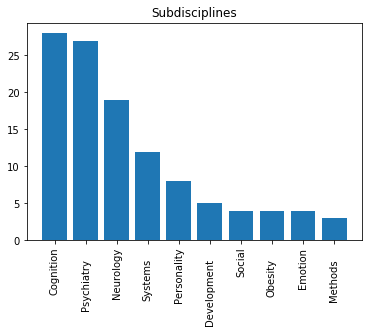

In [67]:
fields = []
for f in data.Subarea:
    for a in f.split(','):
        fields.append(a.strip().replace('Weight Gain/Loss','Obesity'))

a,b = np.unique(fields, return_counts=True)
idx = numpy.argsort(b)[::-1]
a = a[idx]
b = b[idx]
fig,ax = plt.subplots()
ax.bar(a,b)
for tick in ax.xaxis.get_major_ticks()[1::2]:
    tick.set_pad(15)
_ = plt.title('Subdisciplines')
plt.xticks(rotation=90)


Nearly every paper that we reviewed claims to have successfully achieved fMRI-based prediction, although only about half of the articles present this prediction as their primary result. We further assessed the the literature for a number of common errors.

#### 1. Inappropriate use of “prediction” 

Our literature review found that it was common for researchers to use the word “prediction” in the context of analyses that simply demonstrate a statistical association between two variables.  As we outline in more detail below, such results do not provide sufficient evidence for generalizable prediction, due to the "double-dipping" involved when the model is trained and then assessed using the same data. 46% of the papers in the litreature made this sort of inappropriate claim of predictive accuracy. 


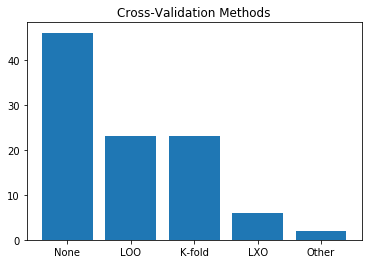

In [82]:

unique, counts = np.unique(data.CV, return_counts=True)
idx = numpy.argsort(counts)[::-1]
unique = unique[idx]
counts = counts[idx]


explode = (0,0.1,0.1,0,0)
plt.bar(unique,counts)

_ = plt.title('Cross-Validation Methods')

#### 2. Inappropriate cross-validation procedures

Cross-validation is a commonly used procedure whereby the utility of a predictive algorithm is confirmed by iteratively training and testing the model on subsets of the data. For example, one might train a model on the first 90% of a data set and test it on the last 10%—and then repeat that process nine times with the other possible test sets, in a process known as 10-fold cross-validation. Another popular cross-validation procedure is leave-one-out cross-validation, in which the model is trained on n - 1 data and tested on the remaining individual, a process that is repeated for each datum. 

LOO is by far the most popular cross-validation procedure in the current literature; of the papers that use cross-validation, about 46% (23) used LOO only, and 11% (6) used a modification of the LOO procedure (LXO in Figure <b>X</b>). As we demonstrate below, LOO can exhibit substantial bias in the context of predicting continuous variables.

#### 3. Insufficient sample sizes

While performing some sort of cross-validation is critical in order to avoid Error 1, it is known that cross-validation procedures are not a magical potion. In particular, the use of cross-validation on small-n data can lead to highly variable estimates of predctive accuracy [@varo:2018], which in the context of analytic flexibility and publication bias can lead to a literature with highly inflated estimates of predictive accuracy.  An assessment of sample sizes in our liteature review showed a high prevalence of small sample sizes, with more than half of the samples smaller than 50, and 15% of the studies having samples smaller than 20.


Proportion of samples smaller than 50: 0.51
Proportion of samples smaller than 20: 0.14


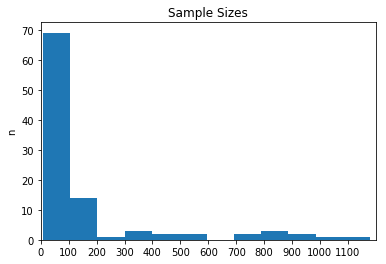

In [80]:
plt.hist(data.n,bins=12)
plt.xticks(np.arange(0,1200,step=100))
plt.xlim(0,1200)
plt.ylabel('n')
_ = plt.title('Sample Sizes')

print('Proportion of samples smaller than 50:',np.mean(data.n<50))
print('Proportion of samples smaller than 20:',np.mean(data.n<20))

#### 4. Insufficient isolation of test data 

The utility of cross-validation is predicated on the isolation of the test data during the fitting of models to the training data.  While nearly all of the papers in our review appeared to follow this critical guideline (and often note it explicitly in publications), there are cases when leakage can occur due to the use of standard preprocessing operations.  In particular, when dimensionality reduction is performed on the full dataset prior to cross-validation, then there is a potential for leakage of information from the test set into the training set, by influencing the dimensionality reduction solution.  (*I AM NOT SURE WE ACTUALLY WANT TO INCLUDE THIS, UNLESS WE ARE GOING TO DO SOME SIMULATIONS*).

21% of the papers in our review appeared to potentially suffer from this leakage problem.  In some papers it was clear that dimensionality reduction (usually ICA or PCA) had been performed on the entire dataset prior to crossvalidation, potentially inducing leakage.  However, it was not always possible to ascertain definitively whether the authors had used post-hoc cross-validation, based only on the text of the paper; this was the case for 67% (14) of the potential post-hoc papers. Commonly, a paper will mention ICA or PCA as part of a preprocessing or feature extraction pipeline and articulate the CV method later, without clarifying whether ICA or PCA was conducted on the sample or merely on the training set. A few papers that seemed at risk for post-hoc validation later clarified that ICA or PCA was performed on the training set for each iteration of the CV method, so it is entirely possible that some of the ambiguous papers in fact performed cross-validation properly. Simultaneously, in 33% (7) of potential post-hoc papers, it was clear that dimensionality reduction using the entire dataset had been performed prior to cross-validation. 
<br>
<br>
It is important to mention that not all instances of inappropriate ICA/PCA use are equally worrying—but, nevertheless, we think performing ICA/PCA on the entire data set should always be avoided. If the prediction is based on resting-state fMRI data, then component selection might not necessarily have an effect on the predictive accuracy found during CV, as there is no <i>a priori</i> reason to suspect that, for example, the first principal component will have a stronger relationship to the predictand than the 20th. However, the same does not hold true for task data, because the most explanatory components are presumably related to the predictand and are thus likely to be contaminated by the test set’s relationship to the predictand. Whether the data are collected during resting state or task performance, it remains safest to avoid basing any preprocessing procedures on the entire data set, if prediction is the goal of the study.     
<br>
<br>
Fortunately, it is not difficult to avoid post-hoc cross-validation entirely. One must simply perform all data-processing techniques whose parameters are not determined <i>a priori</i> on each training set and then apply the technique to the test set using the training set’s parameters. In this way, the processed data will remain comparable, but the processed training set will not be affected in any way by the test set. Alternately, if this procedure would prove too computationally demanding, it is entirely valid to use pre-established data parcellation procedures, i.e. procedures determined by previously collected data or by resting state data if the experiment is focused on task-relevant data. For example, one might apply a mask that was established in prior research and therefore is not contaminated by the test data for any iteration of CV.
<br>
<br>
In the following tutorial, we will detail procedures for effective cross-validation and the measures necessary to avoid the pitfalls seen in the review.


## Overfitting and prediction

The concept of overfitting is well known to machine learning researchers but may be less familiar to those trained in standard statistical methods.  Any dataset includes contributions from the underlying generative processes that we wish to model, as well as from measurement noise.  When we fit a model to data, our goal is to approximate the underlying process that generated the data.  The standard approach in statistical modeling is to find the model parameters that best fit the observed data, defined as minimizing the difference between the model's fitted values and the observed data (such as the mean squared error). Note that the term "prediction" is often used in this context in statistical software packages: fitted values from the model are often referred to as "predicted" values, and regressors in a linear model are referred to as "predictors".  This language is unfortunate, because it implies that the accuracy of model fit is an index of predictive validity when it is not.

The fit of a model to a specific dataset can always be improved by increasing the number of parameters in the model; with as many parameters as data points, any dataset can be fit perfectly.  However, as the model becomes more complex than the generative process, the fit of the model starts to reflect the specific noise values in the dataset rather than the underlying generative process; this what is referred to as overfitting.  A telltale sign of overfitting is that the model fits well to the specific dataset used to estimate the model, but fits poorly to new datasets sampled from the sample population. Figure 1 presents an example of this, showing how increasing model complexity results in reduced error for the data used to fit the model, but increasingly poor fit as the model becomes more complex than the true data generating process.




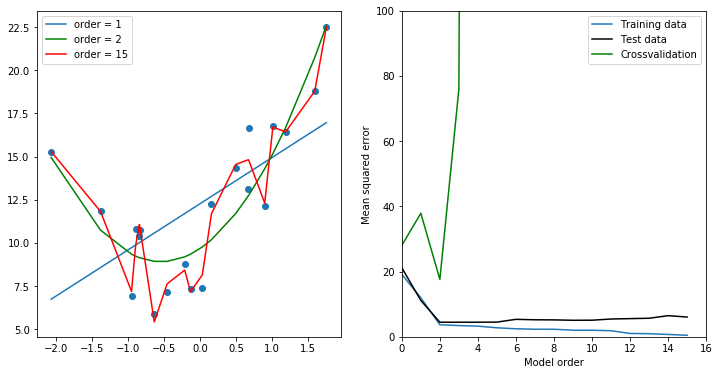

In [2]:
# Figure 1
# true model is quadratic (order 2)
# we generate data from this model and fit models of varying complexity

npts = 20 # number of data points
noise_sd = 2 # noise standard deviation

numpy.random.seed(123456) # set random seed for consistent data

x = numpy.random.randn(npts)
x = numpy.sort(x,axis=None)
x = StandardScaler().fit_transform(x[:,numpy.newaxis])

X = PolynomialFeatures(degree=2).fit_transform(x)
beta=[10,3,3]
Y_train = X.dot(beta) + numpy.random.randn(npts)*noise_sd
Y_test = X.dot(beta) + numpy.random.randn(npts)*noise_sd

coefs={}
model_order_range = 16
mse={'train':numpy.zeros(model_order_range),
    'test':numpy.zeros(model_order_range),
    'cv':numpy.zeros(model_order_range)}

lm = {}
model_X = {}
cv_results = {}

for model_order in range(model_order_range):
    model_X[model_order] = PolynomialFeatures(degree=model_order).fit_transform(x)
    lm[model_order] = LinearRegression(fit_intercept=False)
    lm[model_order].fit(model_X[model_order],Y_train)
    coefs[model_order]=lm[model_order].coef_
    mse['train'][model_order]=numpy.mean((Y_train - lm[model_order].predict(model_X[model_order]))**2)
    mse['test'][model_order]=numpy.mean((Y_test - lm[model_order].predict(model_X[model_order]))**2)
    
    # also compute cross-validation score
    cv_results[model_order] = model_selection.cross_validate(LinearRegression(fit_intercept=False),
                                               model_X[model_order],
                                               Y_train,cv=4,
                                               scoring='neg_mean_squared_error',
                                               return_train_score=False)
    mse['cv'][model_order] = -1*numpy.mean(cv_results[model_order]['test_score'])
   
# plot data points vs model fits

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x,Y_train)
plt.plot(x,lm[1].predict(model_X[1]))
plt.plot(x,lm[2].predict(model_X[2]),color='g')
plt.plot(x,lm[15].predict(model_X[15]),color='r')
plt.legend(['order = 1','order = 2','order = 15'])
# perform crossvalidation to estimate out-of-sample fit


# plot MSE

plt.subplot(1,2,2)
plt.plot(mse['train'])
plt.plot(mse['test'],color='k')
plt.plot(mse['cv'],color='g')
plt.axis([0,model_order_range,0,100])
plt.ylabel('Mean squared error')
plt.xlabel('Model order')
plt.legend(['Training data','Test data','Crossvalidation'])

*Figure 1*: A depiction of overfitting.  Left: A simulated dataset generated from a quadratic model (i.e., polynomial order = 2), shown in blue dots.  The best fitting models are shown for order 1 (linear; blue), order 2 (quadratic; green), and order 15 (red).  The complex model clearly overfits the dataset, adapting itself to the noise evident in specific datapoints.  Right: The mean squared error (MSE) for the model assessed against the dataset used to train the model (blue), and against a separate dataset sampled from the same generative process with different random measurement error (black).  The MSE decreases for the training dataset as the complexity increases, whereas for the test dataset the MSE is lowest for order = 2 (i.e. the true model).  The MSE estimated using cross validation (green) is also lowest for the true model; note that it takes very large values for model orders greater than 3, falling outside the axes of the chart.

Because we don't generally have a separate test dataset to assess the generalization of our model, the standard approach in machine learning to address overfitting is to assess model fit using *crossvalidation*, which uses subsets of the data to iteratively train and test the predictive performance of the model.  The simplest form of crossvalidation is known as *leave-one-out*, in which case the model is fitted while iteratively leaving out each data point and then predicting the value of the left-out point.  A more general crossvalidation approach is known as *K-fold crossvalidation*, in which the data are split into *K* different subsets, and the model is successively trained on the remainder of the data (leaving out each subset) and then testing the predictive performance of the model on the held-out subset.  As shown in Figure 1, this approach can also help discover the model that will provide the best predictive performance on other data.

## How optimistic are in-sample model fits?



As shown above, it is very common for investigators to report estimates of in-sample model fit in service of claims about "prediction". However, the concept of overfitting (and the related concept of "shrinkage" - Copas REF) suggests that any model is likely to fit better to the dataset used to estimate the model, compared to a new dataset sampled from the same population.  This means that any estimate of model fit obtained from a dataset will be an overly optimistic estimate of the true predictive accuracy on a new dataset, because the in-sample estimate is not a true prediction, but rather a post-diction based on knowing the exact data (signal and noise).

The left panel of Figure 2 shows an example of how the optimism of in-sample fits depends on the nature of the statistical model -- in this case, we use a simple linear model but vary the number of irrelevant independent variables in the model. As the number of variables increases, the fit of the model to the sample increases, due to overfitting.  Even for a single variable, the fit of the model is inflated compared to new data or crossvalidation, which provide very similar estimates of out-of-sample predictive accuracy.  The optimism of in-sample fits is also a function of sample size, as shown in the right panel of Figure 2.  

In [27]:
## Simulate optimism as a function of model size

def logistic_simulation(npts = 100, p_disease = 0.5,
                        nvars = 40, noise_sd = 2.5,
                        betaval=2, cv=model_selection.KFold(4, shuffle=True)):
    # design matrix
    # first column reflects healthy (0) vs disease (1)
    # remaining columns are random noise
    X = numpy.zeros((2*npts,1))
    # Created disease in data used for model fitting
    X[:int(npts*p_disease)]=1
    # Created disease in data used for validation
    X[npts:(npts + int(npts*p_disease))]=1
    #X = X - numpy.mean(X)
    if nvars > 1:
        noise = numpy.random.randn(npts*2*(nvars-1)).reshape((2*npts,nvars-1))
        noise = StandardScaler().fit_transform(noise)
        X = numpy.hstack((X,noise))
    betas = numpy.zeros(nvars)

    # only the disease variable has true relationship
    betas[0] = betaval
    Y = X.dot(betas) + numpy.random.randn(2*npts)*noise_sd
    Y = (Y > 0).astype('int')

    # create a left-out dataset to compare to CV
    X_new = X[npts:]
    Y_new = Y[npts:]
    X = X[:npts]
    Y = Y[:npts]

    acc = {'insample':numpy.zeros(nvars),
           'newdata':numpy.zeros(nvars),
           'cv':numpy.zeros(nvars)}


    lr = LogisticRegression(solver='lbfgs', fit_intercept=True)

    for i in range(nvars):
        X_i = X[:,:(i+1)]
        X_i_new = X_new[:,:(i+1)]
        lr.fit(X_i,Y)
        acc['insample'][i] = metrics.accuracy_score(Y,lr.predict(X_i))
        acc['newdata'][i] = metrics.accuracy_score(Y_new,lr.predict(X_i_new))

        cv_results = model_selection.cross_validate(LogisticRegression(solver='lbfgs',
                                                                       fit_intercept=True),
                                                   X_i,
                                                   Y,cv=cv,
                                                   scoring='accuracy',
                                                   return_train_score=True)
        acc['cv'][i] = numpy.mean(cv_results['test_score'])
        #acc['insample'][i] = numpy.mean(cv_results['train_score'])

    return(acc)



In [30]:
# run simulations
acc_estimates = []
nruns = 100
nvars=40
for i in range(nruns):
    acc_estimates.append(logistic_simulation(betaval=0,
                                             nvars=nvars))
    
# summarize accuracy data
acc = {'insample':[],
        'newdata':[],
        'cv':[]}

for i in range(len(acc_estimates)):
    for k in acc:
        if i == 0:
            acc[k] = acc_estimates[i][k]
        else:
            acc[k] = numpy.vstack((acc[k],acc_estimates[i][k]))

all_acc=[]
for k in acc:
    acc[k] = pandas.DataFrame(acc[k]).melt()
    acc[k]['vartype'] = k
    if len(all_acc) == 0:
        all_acc = acc[k]
    else:
        all_acc = pandas.concat((all_acc,acc[k]))


In [28]:
# simulate overfitting as a function of sample size

acc_estimates_sampsize = {}
nruns = 1000
sampsizes = 2**numpy.arange(5,11)

for i,sampsize in enumerate(sampsizes):
    acc_estimates_sampsize[sampsize] = []
    for j in range(nruns):
        acc_estimates_sampsize[sampsize].append(logistic_simulation(npts=sampsize,
                                                                nvars=5,betaval=0))
        
# summarize sample size data
acc_sampsize = {'insample':numpy.zeros((nruns,len(sampsizes))),
        'newdata':numpy.zeros((nruns,len(sampsizes))),
        'cv':numpy.zeros((nruns,len(sampsizes)))}


for i in range(nruns): # simulations
    for j,sampsize in enumerate(sampsizes): # sample sizes
        for k in acc_sampsize: # measures 
            acc_sampsize[k][i,j] = acc_estimates_sampsize[sampsize][i][k][0]

all_acc_sampsize=[]
for k in acc_sampsize:
    acc_sampsize[k] = pandas.DataFrame(acc_sampsize[k]).melt()
    acc_sampsize[k]['vartype'] = k
    if len(all_acc_sampsize) == 0:
        all_acc_sampsize = acc_sampsize[k]
    else:
        all_acc_sampsize = pandas.concat((all_acc_sampsize,acc_sampsize[k]))



/home/varoquau/dev/scipy/scipy/stats/stats.py:1711: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


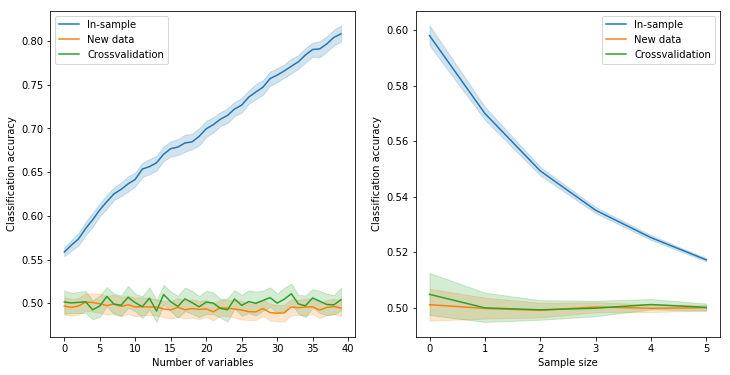

In [31]:
# make figure
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
seaborn.lineplot(x='variable',y='value',hue='vartype',data=all_acc)
plt.ylabel('Classification accuracy')
plt.xlabel('Number of variables')
plt.legend(['In-sample','New data','Crossvalidation'])


# plot sample size data
plt.subplot(1,2,2)
seaborn.lineplot(x='variable',y='value',hue='vartype',data=all_acc_sampsize)
plt.ylabel('Classification accuracy')
plt.xlabel('Sample size')
plt.legend(['In-sample','New data','Crossvalidation'])


*Figure 2*: Left panel: Classification accuracy as a function of the number of variables in the model.  The data were generated using a single variable (which is the first variable in the list of variables); the remaining variables were simply random normal variables with no intended relationship to the outcome.  The blue line shows that in-sample classification accuracy is heavily inflated by the presence of unrelated variables in the model, due to the fitting of noise in those variables. The black line shows the results for testing the fitted model to a new dataset generated in the same way, and the green line shows the accuracy results using crossvalidation.  Crossvalidation prevents the inflated estimate of prediction accuracy, providing an estimate that is much more similar to that expected with a new dataset.  Right panel: Classification accuracy for the model with 5 variables (1 true generating variable and 4 noise variables) as a function of sample size.  Optimism (the difference between in accuracy between in-sample and crossvalidated/new data accuracy) is substantially higher for smaller sample sizes.  Shaded areas indicate 95% confidence intervals estimated via the bootstrap.

## Quantifying classification accuracy

In a classification problem, we wish to quantify our ability to accurately predict class membership, such as the presence of a disease or a cognitive state.  When the number of members in each class is equal, then average accuracy (i.e. the proportion of correct classifications, as used in the examples in Figure 2) is a reasonable measure of predictive accuracy.  However, if there is any imbalance between the frequencies of the different classes, then this is a misleading measure.  Take the following example of a predictive model for a disease that occurs in one out of every 1000 individuals:

|       Test result/Disease        | No disease | Disease |
|---------------|------------|---------|
| Predict disease | 0          | 0       |
| Predict no disease | 999        | 1       |




In [7]:
disease = numpy.zeros(1000)
disease[0] = 1
prediction = numpy.zeros(1000)
print(metrics.accuracy_score(disease,prediction))
print(metrics.balanced_accuracy_score(disease,prediction))



0.999
0.5


In this case, our classifier predicts that no one has the disease, but its average accuracy is 99.9%, because of the low frequency of the disease.  A measure commonly used to address this problem is *balanced accuracy*, which is the average of predictive accuracy for each class. In this example, balanced accuracy is 0.5, correctly reflecting the lack of true predictive performance.  It is generally recommended to use balanced accuracy, since it is equivalent to overall accuracy when classes are equally frequent, but properly accounts for imbalance when it occurs.


**discuss ROC curves?**

**discuss stratified cross validation?**



## Quantifying predictive accuracy for continuous variables: Here be dragons

It is increasingly common to apply predictive modeling in cases where the outcome variable is continuous rather than discrete -- that is, in regression rather than classification problems. For example, a number of studies in cognitive neuroscience have attempted to predict behavioral measures such as IQ or personality test scores from neuroimaging data (REFS).  A predictive analysis using regression requires two important choices --  crossvalidation method and measure of predictive accuracy -- and both of these have the potential to result in misleading results.

First we demonstrate the problem, and then outline its cause and solutions.  Let's say that we have collected data for a study with the aim of predicting some physical quantity based on some measured variable, but our detector for the physical quantity is broken, such that it only reflects random measurement noise.  To quantify our predictive accuracy, we perform leave-one-out crossvalidation using linear regression, and we quantify our predictive accuracy by computing the correlation between predicted values and true values, and squaring that value to give us an "r-squared", which is a measure of the amount of variance accounted for in the data. 

Figure 3 shows the simulated data on the left, showing no relation between X and Y.   Naively we would expect that our predictive accuracy is zero, since the data comprise only measurement noise. However, when we perform crossvalidation and compute predictive accuracy by squaring the correlation between observed and predicted values, we see that we can predict almost 70% of the variance using our model!  The right panel in Figure 3 shows that this reflects the fact that the predicted values are actually negatively correlated with the true values, and squaring this negative correlation coefficient gives us a positive r-squared.  

Text(0,0.5,'predicted value')

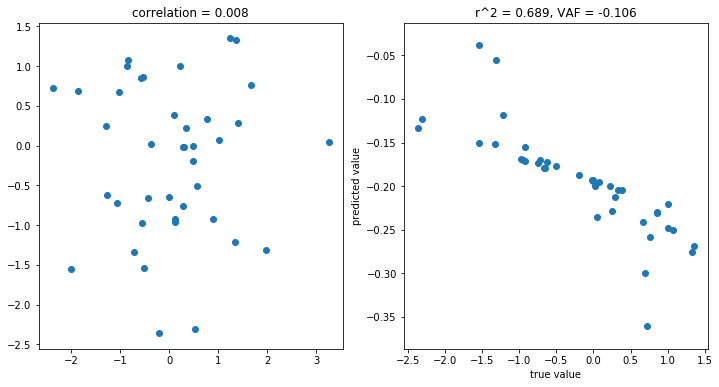

In [9]:
## generate null data and perform regression cross-validation
numpy.random.seed(12345)
npts = 40
X = numpy.random.randn(npts)
y = numpy.random.randn(npts)

loo = LeaveOneOut()
lr = LinearRegression()
pred = numpy.zeros(y.shape)
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr.fit(X_train[:,numpy.newaxis],y_train)
    pred[test_index] = lr.predict(X_test[:,numpy.newaxis])
    
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(X,y)
plt.title('correlation = %0.3f'%numpy.corrcoef(X,y)[0,1])


plt.subplot(1,2,2)
plt.scatter(y,pred)
plt.title('r^2 = %0.3f, VAF = %0.3f'%(numpy.corrcoef(y,pred)[0,1]**2,
         metrics.r2_score(y,pred)))
plt.xlabel('true value')
plt.ylabel('predicted value')

*Figure 3*: A demonstration of the problematic application of crossvalidation to continuous variables, using random data with no true predictive relationship (shown in the left panel).  The right panel shows the true value for each datapoint plotted against the predicted value using leave-one-out crossvalidation; the "r^2" value is obtained by squaring the correlation coefficient, while the variance accounted for (VAF) was computed using the scikit-learn *r2_score()* function.

Why does this negative relationship between predicted and actual values occur?  Figure 4 shows a schematic with a smaller number of data points.  The fundamental problem is that the distribution of X values is different between the different training folds, a problem exacerbated by the use of leave-one-out crossvalidation.  Data points lying on the extremes of the X distribution have substantial leverage on the regression solution, such that leaving them out results in regression lines that are opposite in direction to the line for the full dataset.  This results in predictions that are anticorrelated with the true values.

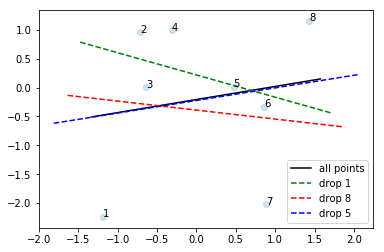

In [10]:
# figure showing biased prediction

def abline(slope, intercept,plt_sym='-',color='k'):
    """
    Plot a line from slope and intercept
    adapted from https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib
    """
    axes = plt.gca()
    x_vals = numpy.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, plt_sym,color=color)

    
    
numpy.random.seed(1234)
X = numpy.random.randn(8)
Y = numpy.random.randn(8)
idx = numpy.argsort(X)
X = X[idx].reshape((8,1))
Y = Y[idx]

plt.scatter(X,Y,alpha=0.2)
lr = LinearRegression(fit_intercept=True)
lr.fit(X,Y)
abline(lr.coef_[0],lr.intercept_)
for i in range(8):
    plt.annotate('%d'%int(i+1),[X[i],Y[i]])
    
# compute regression lines, dropping each value
loo = LeaveOneOut()
regparams = numpy.zeros((8,2))
for train_index,test_index in loo.split(X):
    lr.fit(X[train_index],Y[train_index])
    regparams[test_index,:] = [lr.coef_[0],lr.intercept_]
    
abline(regparams[0,0],regparams[0,1],'--','g')
abline(regparams[7,0],regparams[7,1],'--','r')
abline(regparams[4,0],regparams[4,1],'--','b')

plt.legend(['all points','drop 1','drop 8','drop 5'])




*Figure 4*: An example of anti-correlated regression predictions using leave-one-out crossvalidation.  The regression line fitted to the full dataset (solid black line) has a slightly positive slope.  Dropping data points near the overall regression line has little impact on the resulting slope (e.g., dashed blue line showing slope after dropping data point 5), but dropping high-leverage data points at the extremes of the X distribution has major impact on the resulting regression lines (e.g., dashed green and red lines showing impact of dropping points 1 and 8 respectively), changing the slope from positive to negative.

## Quantifying variance accounted for: "R-squared" versus r^2

A popular metric for predictive accuracy with continuous variables is the coefficient of determination ($R^2$), which quantifies the amount of variance in the data accounted for by a linear model.  This is defined as:

$$
R^2 = 1 - \frac{\text{residual sum of squares}}{\text{total sum of squares}}
$$

The use of the label "r-squared" for the coefficient of determination suggests that it is equivalent to the square of the correlation coefficient between the data and the model predictions -- which it is, when it is computed on the basis of a model fit to the same data (as long as the model includes an intercept term, which ensures that the mean of the predicted values is the same as the mean of the actual values). However, when the model is fitted to one dataset and then applied to another dataset, then this assumption is violated, and the equivalence between the coefficient of determination and the square of the correlation coefficient no longer holds. This also explains how the value of the coefficient of determination computed as shown above can take on negative values.  This occurs in cases when the residual sum of squares is greater than the total sum of squares in the data, which can occur when the model fits the data worse than the mean of the data.  

For this reason, the shorthand computation of the coefficient of determination via squaring the correlation between the observed and predicted values in crossvalidation should *never* be used as a measure of predictive accuracy. Instead, the amount of explained variance should be computed using the sum of squares formulation (e.g., as implemented in the `r2_score()` function in scikit-learn), in which anti-correlated predictions are associated with a negative coefficient of determination.

## Cross validation requires large samples

Previous work (Varoquaux, 2017, CV Failure) has highlighted the problems with application of cross-validation with small samples, focusing primarily on the variability of accuracy estimates.  However, small samples also exacerbate the problem highlighted here, due to the relatively stronger effects of individual data points. In Figure 5 we explore the relationship between sample size and predictive accuracy bias, both in the context of no true relationship (top row) and in the context of a moderately strong relationship (bottom row). In addition to leave-one-out crossvalidation, we also include two other crossvalidation methods, to show that crossvalidation methods can have important impacts on resulting accuracy estimates.

There are several points evident from Figure 5.  First, the combination of leave-one-out crossvalidation and correlation as a measure of predictive performance is badly biased; when there is no signal the correlation is negative, and when there is true signal it is heavily underestimated.  Second, this bias is particular problematic at small sample sizes.  Third, all crossvalidation methods exhibit this bias, though to a lesser extent for K-fold or balanced K-fold crossvalidation (which finds folds with similar distributions on the Y variable).  Fourth, mean squared error performs much better as a measure of predictive performance, particularly when using leave-one-out crossvalidation; K-fold methods show somewhat inflated MSE estimates compared to leave-one-out. Fifth, in-sample predictive accuracy shows a bias with small samples, such that positive correlation between predicted and true values is observed even when there is no true relationship.



In [60]:
def cvtest(nsubs,cv_fns=None,beta=0.2,
           scale_X=True,scale_Y=True,
          scale_within_loop=False):
    """
    - function to perform a single simulation run
    nsubs: number of subjects per simulation
    cv_fns: dict of CV functions
    beta: strength of true relationship
    measure: 'corr': correlation, 'MSE': mean squared error
    """
    results_corr=[]
    results_mse=[]
    
    if cv_fns is None:
        cv_fns={'LOO':model_selection.LeaveOneOut(),
               'BalancedKFold':BalancedKFold(nfolds=4,pthresh=0.99),
               'KFold':model_selection.KFold(n_splits=4,shuffle=True)}

    # just use simple linear regression
    clf=LinearRegression()
    
    # create random X and Y variables
    X=numpy.random.randn(nsubs).reshape((nsubs,1))
    if scale_X:
        X = (X - numpy.mean(X))/numpy.std(X)
    Y=numpy.random.randn(nsubs).reshape((nsubs,1)) + X*beta
    if scale_Y:
        Y = (Y - numpy.mean(Y))/numpy.std(Y)

    scaler=StandardScaler()
    # first run leave-one-out CV
    for method in cv_fns:
        cv=cv_fns[method]
        pred=numpy.zeros((nsubs,1))
        for train_index, test_index in cv.split(X,Y):

            X_train, X_test = X[train_index,:], X[test_index,:]
            y_train, y_test = Y[train_index], Y[test_index]
            if scale_within_loop:
                X_train=scaler.fit_transform(X_train)
                X_test=scaler.transform(X_test)
            clf.fit(X_train,y_train)

            pred[test_index,0]=clf.predict(X_test)[:,0]
        corr=numpy.corrcoef(pred[:,0],Y[:,0])[0,1]
        MSE=numpy.sqrt(numpy.mean((pred-Y[:,0])**2))
        results_corr.append([method,corr])
        results_mse.append([method,MSE])
    # also include in-sample
    clf.fit(X,Y)
    pred=clf.predict(X)
    corr=numpy.corrcoef(pred[:,0],Y[:,0])[0,1]
    MSE=numpy.sqrt(numpy.mean((pred-Y[:,0])**2))
    results_corr.append(['insample',corr])
    results_mse.append(['insample',MSE])
    return(results_corr,results_mse)
    
def plot_results(results,beta,measure):
    results_df = pandas.DataFrame(results,columns=['n','method',measure])
    seaborn.lineplot(x='n',y=measure,hue='method',data=results_df)
    plt.title('beta = %0.3f'%beta)
    if measure=='MSE':
        plt.ylim((0.99,1.07))
        plt.ylabel('Mean squared error')
    elif measure=='corr':
        plt.ylabel('Correlation(predicted,true)')
        plt.plot([results_df.n.min(),results_df.n.max()],[beta,beta],'k:')
 

def run_sim(nruns,beta,
            sampsizes=[24,48,96,192,512,1024]):
    results_corr=[]
    results_mse=[]
    for n in sampsizes:
        for run in range(nruns):
            result_corr,result_mse=cvtest(n,beta=beta)
            for r in result_corr:
                results_corr.append([n]+r)
            for r in result_mse:
                results_mse.append([n]+r)
                
    return(results_corr,results_mse)

In [17]:
beta=.2
results_corr,results_mse=run_sim(nruns=100,beta=beta)

beta_null=0.
results_corr_nosig,results_mse_nosig=run_sim(nruns=100,beta=beta_null)

/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


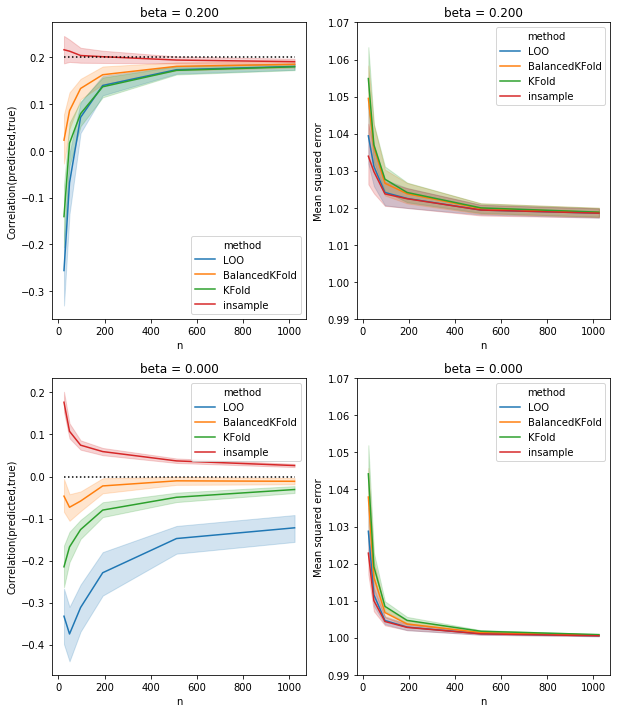

In [61]:
# Make figure

plt.figure(figsize=(10,12))
plt.subplot(2,2,1)
plot_results(results_corr,beta,'corr')

plt.subplot(2,2,2)
plot_results(results_mse,beta,'MSE')

plt.subplot(2,2,3)
plot_results(results_corr_nosig,beta_null,'corr')

plt.subplot(2,2,4)
plot_results(results_mse_nosig,beta_null,'MSE')

*Figure 5*: Predictive accuracy as a function of true effect size and sample size, using multiple crossvalidation methods.  The top row shows performance when there is a small true signal (r=0.2), while the bottom row shows performance under the null hypothesis. The left column shows the Pearson correlation between predicted and true values, while the right column shows the mean squared error. Red lines show data for in-sample correlation/error, while other lines show results using several crossvalidation methods; shaded area represents the 95% confidence interval computed via the bootstrap.

#### Best practices for predictive modeling

Based on the foregoing results, we have several suggestions for best practices for predictive modeling:

* In-sample model fit indices should never be reported as evidence for predictive accuracy, based on the fact that they can greatly overstate the evidence for prediction, and can take on positive values even in the absence of true generalizable predictive ability.
* Predictive analyses should never be performed on data after variable selection, if the variable selection was informed to any degree by the data themselves (i.e. "post-hoc crossvalidation").  Otherwise, the estimated predictive accuracy will be inflated due to circularity.  
* Prediction analyses should never be performed with samples smaller than about 100, based on the finding that predictive accuracy estimates with small samples are inflated and highly variable.
* Multiple measures of prediction accuracy should always be examined and reported. For regression analyses, measures of correlation or variance accounted for (such as r-squared) should always be accompanied by measures of unsigned error (such as mean squared error or mean absolute error). For classification analyses, balanced accuracy should be presented, and confusion matrices should be examined.
* The coefficient of determination should be computed using the sums of squares formulation rather than by squaring the estimated correlation coefficient.
* K-fold cross-validation is generally preferable to leave-one-out.
* Performance of the prediction model under the null should be assessed by repeatedly running the entire prediction pipeline while randomly shuffling the outcome variable.  This assumes that observations are exchangeable, which can fail in cases where there are relationships between data points.


In [4]:
# convert paper to pdf with references via markdown using pandoc

import subprocess

def run_shell_cmd(cmd,cwd=[],verbose=False):
    """ run a command in the shell using Popen
    """
    stdout_holder = []
    stderr_holder = []

    if cwd:
        process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE,
                                        stderr=subprocess.PIPE,cwd=cwd)
    else:
        process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE,
                                        stderr=subprocess.PIPE)

    for line in process.stdout:
        if verbose:
             print(line.strip().decode('UTF-8'))
        stdout_holder.append(line.strip().decode('UTF-8'))
    for line in process.stderr:
        if verbose:
            print(line.strip().decode('UTF-8'))
        stderr_holder.append(line.strip().decode('UTF-8'))

    process.wait()
    return (stdout_holder,stderr_holder)


#automatic document conversion to markdown and then to word
#first convert the ipython notebook paper.ipynb to markdown
run_shell_cmd("jupyter nbconvert --to markdown PredictionPaper.ipynb")
#next convert markdown to ms word
run_shell_cmd(' '.join(["pandoc -s PredictionPaper.md -t latex",
                        "-o PredictionPaper.pdf --filter pandoc-citeproc",
                        "--bibliography='PredictionPaper.bib' --csl='apa.csl'"]))


([], [])